![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/legal-nlp/05.3.ZeroShot_Legal_NER.ipynb)

#  Zero-Shot Named Entity Recognition in Spark NLP

In this notebook, you will find an example of Zero-Shot NER model (`legner_roberta_zeroshot`) that is the first of its kind and can detect any named entities without using any annotated dataset to train a model. 

`ZeroShotNerModel` annotator also allows extracting entities by crafting appropriate prompts to query **any RoBERTa Question Answering model**. 


You can check the model card here: [Models Hub](https://nlp.johnsnowlabs.com/2022/08/29/zero_shot_ner_roberta_en.html)

# Installation

In [ ]:
! pip install -q johnsnowlabs

## Automatic Installation
Using my.johnsnowlabs.com SSO

In [ ]:
from johnsnowlabs import nlp, legal

# nlp.install(force_browser=True)

## Manual downloading
If you are not registered in my.johnsnowlabs.com, you received a license via e-email or you are using Safari, you may need to do a manual update of the license.

- Go to my.johnsnowlabs.com
- Download your license
- Upload it using the following command

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

- Install it

In [ ]:
nlp.install()

# Starting

In [ ]:
spark = nlp.start()

👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_7163 (2).json
👌 Launched cpu optimized session with with: 🚀Spark-NLP==4.2.4, 💊Spark-Healthcare==4.2.4, running on ⚡ PySpark==3.1.2


#### Answering Questions on Legal Texts
One of the latests biggest outcomes in NLP are **Language Models** and their ability to answer questions, expressed in natural language.

**Question Answeering (QA)** uses specific Language Models trained to carry out **Natural Language Inference (NLI)**

**NLI** works as follows:
- Given a text as a Premise (P);
- Given a hypotheses (H) as a question to be solved;
   - Then, we ask the Language Model is H is `entailed`, `contradicted` or `not related` in P.

For doing that, several examples (hypotheses) are provided and sent to the Language model, which will use `NLI (Natural Language Inference)` to check if the any information found in the text matches the examples (confirm the hypotheses).

NLI usually works by trying to confirm or reject an hypotheses. The hypotheses are the `prompts` or examples we are going to provide. If any piece of information confirm the constructed hypotheses (answer the examples we are given), then the hypotheses is confirmed and the Zero-shot is triggered.

> *In February 2017, the Company entered into an asset purchase agreement with NetSeer, Inc.
...
 The Company hereby grants to Seller a perpetual, non-exclusive, royalty-free license.
...
On March 12, 2020, we closed a Loan and Security Agreement with Hitachi Capital American Corp (also known as "Hitachi")
...*

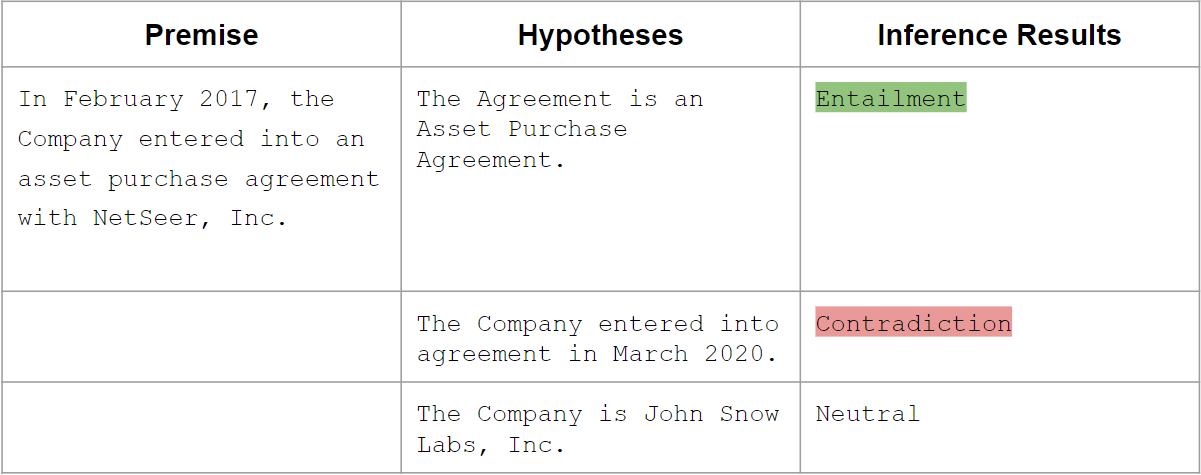

We have built our `Zero-shot` NER and Relation Extraction models on top of Language Models and Question Answering, applying NLI. Since it's a QA model, Zero-shot does not require any training data, just a context and a series of questions.


Let's see it in action.

## Zero-shot Learning: NER

Named Entity Recognition is the NLP task aimed to tag chunks of information with specific labels.

NER has been historically carried out using rule-based approaches, machine learning and more recently, Deep Learning models, including transformers.

If we ignore the traditional rule-based approach, which consisted on having Subject Matter Experts (SME) creating rules using regular expressions, vocabularies, ontologies, etc., the common steps for the rest of Machine Learning based NER approaches were:

1. Collect and clean data
2. Having SME annotating many documents;
3. Create features (only if using ML approaches, since Deep Learning does that feature extraction for you in most cases);
4. Train a model on a training dataset;
5. Evaluate on a test test;

If it is not accurate, go to step number 1.

This process takes a long time, specially if the nature of the use case is complex and requires many examples for the model to learn.

Thankfully, **Zero-shot** comes to help, since it does not require any training data, drastically speeding up the process. *Zero-shot* models can be:

- It can be a model on it’s own, with average accuracy;
- It can be used to preannotate the documents and speed up the process of annotations by SME;
- **Legal NLP** includes *Zero-shot* NER, which uses prompts in form of questions, and retrieves the answers to those questions as tagged chunks of information.

*This is an example of Entity labels and some prompts.*


```
- What is the type of agreement?
- What is the type of license?
- What are the companies in the agreement?
- What is also known as the different compaines?
- Who is the recipient of a license?
````

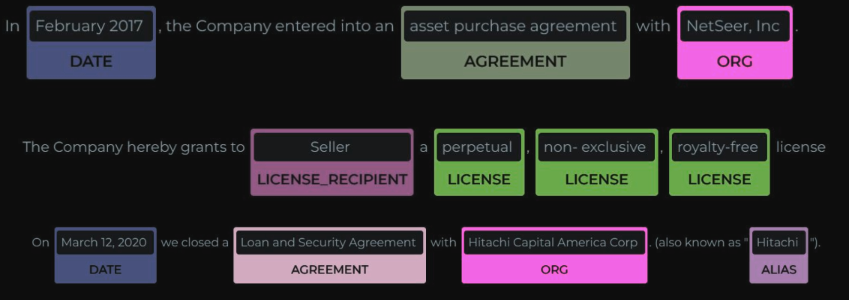

## How is this achieved?
- We check if the question/prompt (Hypotheses) returns `entailment` for any token in the premise (context/text)
- If several tokens in a row entail the hypotheses, the tokens are merged and returned as one `ner_chunk`

# Let's start!

In [ ]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sen = nlp.SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

sparktokenizer = nlp.Tokenizer()\
    .setInputCols("sentence")\
    .setOutputCol("token")

zero_shot_ner = legal.ZeroShotNerModel.pretrained("legner_roberta_zeroshot", "en", "legal/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("zero_shot_ner")\
    .setEntityDefinitions(
        {
            "DATE": ['When was the company acquisition?', 'When was the company purchase agreement?', "When was the agreement?"],
            "ORG": ["Which company?"],
            "STATE": ["Which state?"],
            "AGREEMENT": ["What kind of agreement?"],
            "LICENSE": ["What kind of license?"],
            "LICENSE_RECIPIENT": ["To whom the license is granted?"]
        })


nerconverter = nlp.NerConverter()\
  .setInputCols(["sentence", "token", "zero_shot_ner"])\
  .setOutputCol("ner_chunk")

pipeline =  nlp.Pipeline(stages=[
  documentAssembler,
  sen,
  sparktokenizer,
  zero_shot_ner,
  nerconverter
    ]
)

legner_roberta_zeroshot download started this may take some time.
[OK!]


In [ ]:
from pyspark.sql.types import StructType,StructField, StringType

sample_text = ["""In March 2012, as part of a longer-term strategy, the Company acquired Vertro, Inc., which owned and operated the ALOT product portfolio.""",
              """In February 2017, the Company entered into an asset purchase agreement with NetSeer, Inc.""",
              """This INTELLECTUAL PROPERTY AGREEMENT, dated as of December 31, 2018 (the 'Effective Date') is entered into by and between Armstrong Flooring, Inc., a Delaware corporation ('Seller') and AFI Licensing LLC, a Delaware company (the 'Licensee')""",
              """The Company hereby grants to Seller a perpetual, non- exclusive, royalty-free license"""]

p_model = pipeline.fit(spark.createDataFrame([[""]]).toDF("text"))

res = p_model.transform(spark.createDataFrame(sample_text, StringType()).toDF("text"))

In [ ]:
from pyspark.sql import functions as F

res.select(F.explode(F.arrays_zip(res.ner_chunk.result, res.ner_chunk.begin, res.ner_chunk.end, res.ner_chunk.metadata)).alias("cols")) \
   .select(F.expr("cols['0']").alias("chunk"),
           F.expr("cols['3']['entity']").alias("ner_label"))\
   .filter("ner_label!='O'")\
   .show(truncate=False)

+-------------------------------------+-----------------+
|chunk                                |ner_label        |
+-------------------------------------+-----------------+
|March 2012                           |DATE             |
|Vertro, Inc                          |ORG              |
|February 2017                        |DATE             |
|asset purchase agreement             |AGREEMENT        |
|NetSeer                              |ORG              |
|INTELLECTUAL PROPERTY                |AGREEMENT        |
|December 31, 2018                    |DATE             |
|Armstrong Flooring                   |LICENSE_RECIPIENT|
|Delaware                             |STATE            |
|AFI Licensing LLC, a Delaware company|LICENSE_RECIPIENT|
|Seller                               |LICENSE_RECIPIENT|
|perpetual                            |LICENSE          |
|non- exclusive                       |LICENSE          |
|royalty-free                         |LICENSE          |
+-------------

#### We have just seen how simple it is to obtain the output without having to deal with the hassle of model training.

#### Let's now look at how to enhance the model's predictions in scenarios where there may be incorrectly identified labels or fewer labels overall.

**Let's look at an instance where the text's predictions are incorrect and discuss how to make them better:**

In [ ]:
lp = nlp.LightPipeline(p_model)
sample_text = ["The maximum penalty for a first-time DUI offense in California is up to six months in jail and a fine of up to $1,000 , according to state law.", "The company is required to file its annual report with the state of California by March 31st of each year. Failure to do so may result in fines of $1,000 .", "Pursuant to the laws of the State of Delaware, the company XYZ, Inc. was properly organized and is currently in good standing with its principal place of business located at 123 Main Street, Anytown, USA 12345.","The corporation known as DEF Inc. was incorporated under the laws of the State of Illinois on April 1, 2018 and has its principal place of business at 456 Main Street, Anytown, USA 54321 ."]

# from sparknlp_display import NerVisualizer
for i in range(len(sample_text)):
  print('***'*30,f'Text Number - {i+1}')
  visualiser = nlp.viz.NerVisualizer()
  lp_res_1 = lp.fullAnnotate(sample_text[i])
  visualiser.display(lp_res_1[0], label_col='ner_chunk', document_col='document')

****************************************************************************************** Text Number - 1


****************************************************************************************** Text Number - 2


****************************************************************************************** Text Number - 3


****************************************************************************************** Text Number - 4


#### Here, it is clear that many of the model-identified text entities are incorrect.




1.   We can observe that the **DATE** label has been misidentified in the first text.
2.   The label **LICENSE RECEPIENT** on the second text shouldn't be used to refer to it.
3.   In the 4th text `USA` has been identified as text but it should rather be identified as `ADDRESS`. 




*Let's try to fix these by modifying and including some prompts:*

In [ ]:
zero_shot_ner = legal.ZeroShotNerModel.pretrained("legner_roberta_zeroshot", "en", "legal/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("zero_shot_ner")\
    .setEntityDefinitions(
        {
            "DATE": ['When was the company acquisition?', 'When was the company purchase agreement?', "When was the agreement?"],
            "ORG": ["Which company?"],
            "STATE": ["Which state?"],
            "AGREEMENT": ["What kind of agreement?"],
            "LICENSE": ["What kind of license?"],
            "LICENSE_RECIPIENT": ["To whom the license is granted?"],
            "ADDRESS": ['What is the address of the company'],
            "FINE_RECEPIENT": ['How much fine?']
        })

legner_roberta_zeroshot download started this may take some time.
[OK!]


#### To make the model predictions better, We could think of adding new labels or rephrasing the texts so that the model can better identify the entities inside the text.

From the sentences, it is clear that there are other valuable entities that can improve the model's ability to predict: `FINE RECEPIENT`, `ADDRESS`.



In [ ]:
pipeline =  nlp.Pipeline(stages=[
  documentAssembler,
  sen,
  sparktokenizer,
  zero_shot_ner,
  nerconverter
    ]
)

p_model = pipeline.fit(spark.createDataFrame([[""]]).toDF("text"))

lp = nlp.LightPipeline(p_model)

sample_text = ["The maximum penalty for a first-time DUI offense in California is up to six months in jail and a fine of up to $1,000 , according to state law.", "The company is required to file its annual report with the state of California by March 31st of each year. Failure to do so may result in fines of $1,000 .", "Pursuant to the laws of the State of Delaware, the company XYZ, Inc. was properly organized and is currently in good standing with its principal place of business located at 123 Main Street, Anytown, USA 12345.","The corporation known as DEF Inc. was incorporated under the laws of the State of Illinois on April 1, 2018 and has its principal place of business at 456 Main Street, Anytown, USA 54321 ."]

# from sparknlp_display import NerVisualizer
for i in range(len(sample_text)):
  print('***'*30,f'Text Number - {i+1}')
  visualiser = nlp.viz.NerVisualizer()
  lp_res_1 = lp.fullAnnotate(sample_text[i])
  visualiser.display(lp_res_1[0], label_col='ner_chunk', document_col='document')

****************************************************************************************** Text Number - 1


****************************************************************************************** Text Number - 2


****************************************************************************************** Text Number - 3


****************************************************************************************** Text Number - 4


## Automatic Prompt Generation

If you are curious if prompts can be generated automatically, the answer is - *Yes!* Please check the **Automatic Question Generation** notebook in this workshop.